In [1]:
import os
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [2]:
import pandas as pd
import seaborn as sns
import umap

In [3]:
import dask
import dask.dataframe as ddf
from dask.distributed import Client

In [4]:
import time

In [5]:
# @dask.delayed
def func(hyp_dict, algorithm, df, X, iteration, clustering_on, scores_on):
    filename = f"output_final/dbscan/tuning/{algorithm}_{iteration}_{clustering_on}_{scores_on}_{'_'.join([str(k) + '-' + str(v) for k, v in hyp_dict.items()])}.csv"
    scores = pd.DataFrame(columns=["iteration", "silhouette", "davies_bouldin", "calinski"] + list(hyp_dict.keys()))

    if not os.path.isfile(filename):
        # determine clustering method and predicct labels
        if algorithm == "kmeans":
            kmeans = KMeans(**hyp_dict).fit(df)
            y_pred = kmeans.predict(df)
        elif algorithm == "ward":
            model = AgglomerativeClustering(**hyp_dict).fit(df)
            y_pred = model.labels_
        elif algorithm == "dbscan":
            model = DBSCAN(**hyp_dict).fit(df)
            y_pred = model.labels_
        elif algorithm == "optics":
            model = OPTICS(**hyp_dict).fit(df)
            y_pred = model.labels_
        else:
            print("Clustering algorithm not implemented")
    
        # compute scores
        nclusters = len(np.unique(y_pred))
        if nclusters > 1:
            sil = silhouette_score(X, y_pred)
            db = davies_bouldin_score(X, y_pred)
            cal = calinski_harabasz_score(X, y_pred)
        else:
            sil = np.nan
            db = np.nan
            cal = np.nan
    
        # add scores to df
        scores = pd.DataFrame({"nclusters": nclusters, "iteration": [iteration], "silhouette": [sil], "davies_bouldin": [db], 
                               "calinski": [cal], "clustering_on": [clustering_on], "scores_on": [scores_on]})
        # scores = pd.concat([scores, pd.DataFrame({"nclusters": nclusters, "iteration": [i], "silhouette": [sil], 
        #                                           "davies_bouldin": [db], "calinski": [cal]})])
        # scores.reset_index(inplace=True, drop=True)
        # scores = scores.combine_first(pd.DataFrame.from_dict([hyp_dict]).set_index(pd.Series(len(scores)-1)))
    
        scores.to_csv(filename, index=False)

    return scores

In [6]:
def compute_scores(df, compute_scores_on=None, algorithm="kmeans", iterations=10, clustering_on="original", scores_on="original"):
    if compute_scores_on is not None:
        X = compute_scores_on.copy()
    else:
        X = df.copy()

    hyp_dict = hyps[algorithm]
    hyp_combinations = list(it.product(*hyp_dict.values()))
    res = []
    # scores = pd.DataFrame(columns=["iteration", "silhouette", "davies_bouldin", "calinski"] + list(hyp_dict.keys()))
    for i in range(iterations):
        print(i)
        for h in hyp_combinations:
            # print(h)
            hyp_temp = dict((b, a) for a, b in zip(h, hyp_dict.keys()))
            res.append(func(hyp_dict=hyp_temp, algorithm=algorithm, df=df, X=X, iteration=i, clustering_on=clustering_on, scores_on=scores_on))        

    # scores = pd.concat(res)
    # scores["silhouette"] = scores["silhouette"].astype(float)
    # scores["davies_bouldin"] = scores["davies_bouldin"].astype(float)
    # scores["calinski"] = scores["calinski"].astype(float)
    # scores["iteration"] = scores["iteration"].astype(int)
    # scores["nclusters"] = scores["nclusters"].astype(int)
    # scores["clustering_on"] = clustering_on
    # scores["scores_on"] = scores_on

    return res

In [7]:
def plot_score(df, x, y, save_as=None):
    xmap = {"n_clusters": "Number of clusters", "eps": "Epsilon", "min_samples": "Minimum number of samples"}
    df_mean = df.dropna()[[x, y]].groupby(x).mean()
    if y == "silhouette":
        t = "Silhouette Score"
        optimal_x = df_mean.idxmax().values[0]
    elif y == "davies_bouldin":
        t = "Davies Bouldin Score"
        optimal_x = df_mean.idxmin().values[0]
    elif y == "calinski":
        t = "Calinski Harabasz Score"
        optimal_x = df_mean.idxmax().values[0]

    plt.figure()
    sns.lineplot(df, x=x, y=y)
    plt.ylabel(t)
    plt.xlabel(xmap[x])
    plt.axvline(optimal_x, color="orange")
    plt.tight_layout()
    if save_as:
        plt.savefig(save_as)
    plt.show()

In [8]:
def plot_all_scores(scores, x="n_clusters", algorithm="kmeans", output_path="output/clustering/", save_as_suffix=None):
    if save_as_suffix: 
        plot_score(scores, x, "silhouette", save_as=f"{'silhouette'}_{algorithm}_{x}{save_as_suffix}.png") 
        plot_score(scores, x, "davies_bouldin", save_as=f"{'davies_bouldin'}_{algorithm}_{x}{save_as_suffix}.png")  
        plot_score(scores, x, "calinski", save_as=f"{'calinski'}_{algorithm}_{x}{save_as_suffix}.png")  
    else:
        plot_score(scores, x, "silhouette", save_as=None) 
        plot_score(scores, x, "davies_bouldin", save_as=None)  
        plot_score(scores, x, "calinski", save_as=None) 

In [10]:
def conduct_exps(df, embedding, algorithm, n_iterations=10):
    # define variables
    vars = []
    if algorithm == "kmeans" or algorithm == "ward":
        vars = {"n_clusters": int}
    elif algorithm == "dbscan":
        vars = {"eps": float, "min_samples": int}
    
    # compute clusters on original data, scores on original data ---------------------------------------------------------------------- #
    print("compute clusters on original data, scores on original data")
    coeff_scores_oo = compute_scores(df, compute_scores_on=df, algorithm=algorithm, iterations=n_iterations, 
                                     clustering_on="original", scores_on="original")

    # # compute clusters on original data, scores on embedded data ---------------------------------------------------------------------- #
    # print("compute clusters on original data, scores on embedded data")
    # coeff_scores_oe = compute_scores(df, compute_scores_on=embedding, algorithm=algorithm, iterations=n_iterations, 
    #                                 clustering_on="original", scores_on="embedding")

    # # compute clusters on embedded data, scores on original data ---------------------------------------------------------------------- #
    # print("compute clusters on embedded data, scores on original data")
    # coeff_scores_eo = compute_scores(embedding, compute_scores_on=df, algorithm=algorithm, iterations=n_iterations, 
    #                                 clustering_on="embedding", scores_on="original")

    # compute clusters on embedded data, scores on embedded data ---------------------------------------------------------------------- #
    print("compute clusters on embedded data, scores on embedded data")
    coeff_scores_ee = compute_scores(embedding, compute_scores_on=embedding, algorithm=algorithm, iterations=n_iterations, 
                                    clustering_on="embedding", scores_on="embedding")

    return [coeff_scores_oo, coeff_scores_oe, coeff_scores_eo, coeff_scores_ee]

In [11]:
# define hyperparameter combinations to evaluate
hyps = {"kmeans": {"n_clusters": list(range(2, 16)) + [20, 30, 40, 50, 60], "n_init": ["auto"]},
        "ward": {"n_clusters": range(2, 31), "distance_threshold": [None], "linkage": ["ward"]},
        "dbscan": {"eps": np.linspace(0.01, 0.2, 60), "min_samples": range(2, 12)},
        "optics": {"min_samples": range(1, 16), "max_eps": [np.inf]}}

In [12]:
hyp_dict = hyps["dbscan"]
hyp_combinations = list(it.product(*hyp_dict.values()))

In [13]:
len(hyp_combinations) * 10 

6000

In [14]:
# load data
df_in = pd.read_csv("data/df_wide_knn.csv") 
df = df_in.drop(["LATITUDE", "LONGITUDE", "LEV_M"], axis=1)  # remove geolocation

# scale data
scaler = MinMaxScaler().fit(df)
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)

# compute embedding
embedding = umap.UMAP(min_dist=0.0, n_components=3, n_neighbors=20).fit_transform(df_scaled)

# output directory
output_dir = "output_final/"

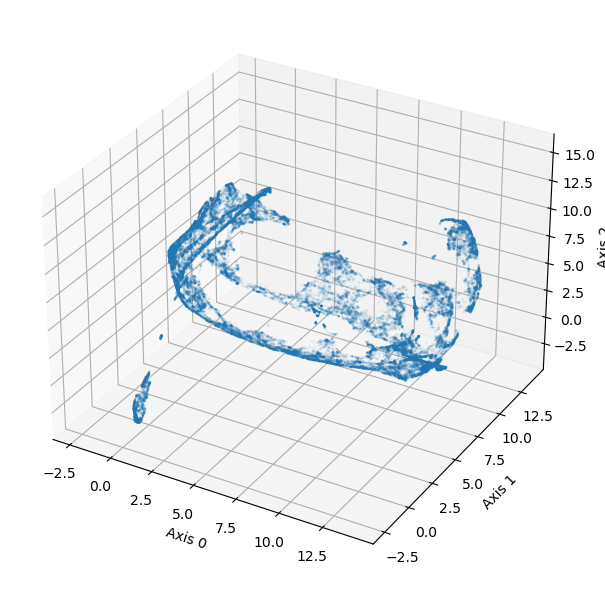

In [16]:
# visualize embedding
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], alpha=0.08, s=2, marker=".")
plt.xlabel("Axis 0")
plt.ylabel("Axis 1")
ax.set_zlabel("Axis 2")
plt.tight_layout()
plt.savefig("output_final/umap_space.png")
plt.show()

In [ ]:
# client = Client(n_workers=4)
# client

# KMeans

In [ ]:
%%time
# compute scores 
scores_kmeans = conduct_exps(df=df_scaled, embedding=embedding, algorithm="kmeans", n_iterations=10)

In [ ]:
%%time
results_kmeans = dask.compute(*[item for row in scores_kmeans for item in row])  # compute flattened list

# runs on 4 workers, <2Gib per worker (bytes stored per worker) -> 1:30 h

In [ ]:
pd.concat(results_kmeans).to_csv("output/kmeans_scores.csv", index=False)

In [ ]:
# %%time (before 31.10.2023 update)
# # 1 iteration = 33min
# # 10 iterations = 4h 50min

# (after 31.10.2023 update)
# # 1 iteration = 
# # 10 iterations = 

# for i, exp in enumerate(scores_kmeans):
#     res = exp.compute()
#     res.to_csv(f"C:/Users/yvjennig/PycharmProjects/phd_repos/clustering/kmeans_scores_{i}.csv", index=False)

In [ ]:
# @ to do: Should I recompute embedding for every iteration of the score computations? (currently not done)

# Agglomerative Ward clustering

In [ ]:
%%time
scores_ward = conduct_exps(df=df_scaled, embedding=embedding, algorithm="ward", n_iterations=10)

In [ ]:
%%time
results_ward = dask.compute(*scores_ward)

beginning around 9Gib per worker, peaks up to 25Gib

CPU times: user 10min 15s, sys: 1min 31s, total: 11min 47s <br>
Wall time: 6h 47min 12s

In [ ]:
pd.concat(results_ward).to_csv("output/ward_scores.csv", index=False)

In [ ]:
# %%time
# for i, exp in enumerate(scores_ward):
#     res = exp.compute()
#     res.to_csv(f"C:/Users/yvjennig/PycharmProjects/phd_repos/clustering/ward_scores_{i}.csv", index=False)

# DBSCAN

In [ ]:
%%time
scores_dbscan = conduct_exps(df=df_scaled, embedding=embedding, algorithm="dbscan", n_iterations=10)

compute clusters on original data, scores on original data
0
1
2
3
4
5
6
7
8
9
compute clusters on embedded data, scores on embedded data
0


In [ ]:
%%time
results_dbscan = dask.compute(*scores_dbscan)

# sth between 30-35h

In [ ]:
pd.concat(results_dbscan).to_csv("output/dbscan_scores.csv", index=False)

In [ ]:
# %%time
# for i, exp in enumerate(scores_dbscan):
#     res = exp.compute()
#     res.to_csv(f"C:/Users/yvjennig/PycharmProjects/phd_repos/clustering/dbscan_scores_{i}.csv", index=False)